https://machinelearningmastery.com/xgboost-for-time-series-forecasting/?__cf_chl_tk=Ys_GJWx4Z.qSLLyF84OVv7O5HwEHC77TOzgb_9zsuPo-1742236350-1.0.1.1-eH9oFZyZ8iX0lWeKJfn_cKnIxxWQhnQMuQ7jYe5wTxU

In [2]:
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests

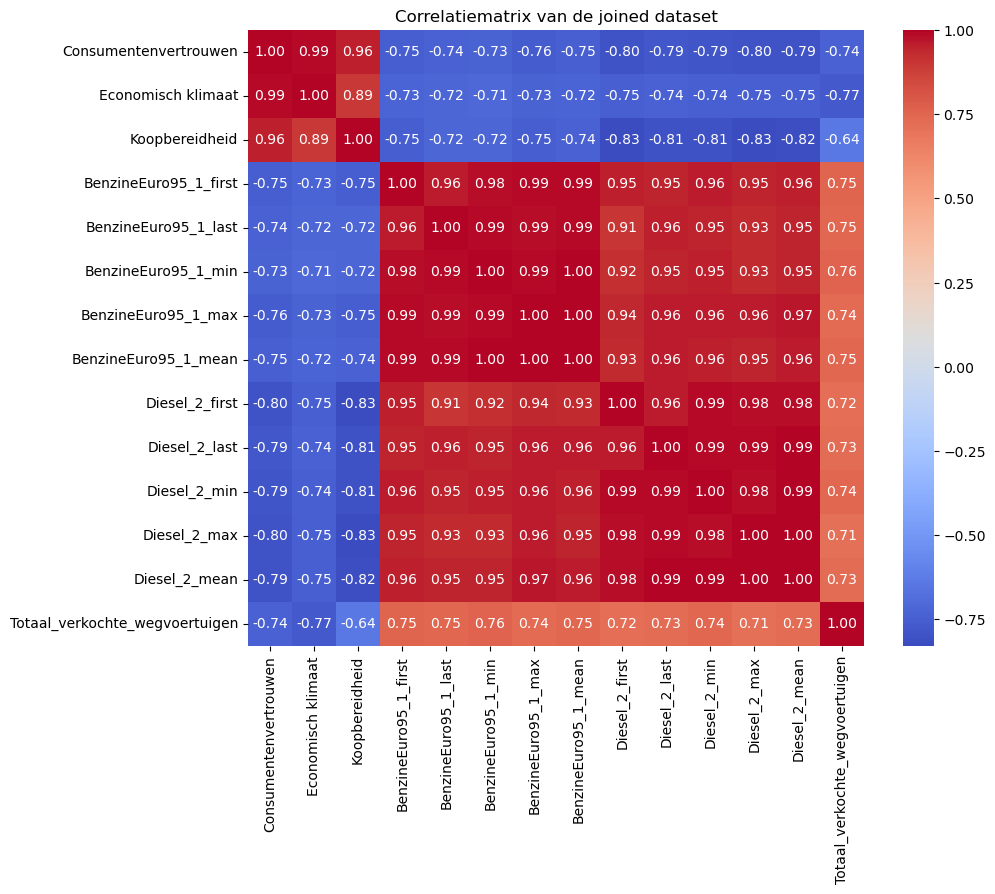

In [5]:
# Correlatiematrix berekenen
correlation_matrix = pd.read_csv(r"E:\Nieuw dataset\df_joined_datasets.csv")
correlation_matrix = correlation_matrix.corr(numeric_only=True)

# Heatmap plotten
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlatiematrix van de joined dataset")
plt.show()


De correlatiematrix laat zien dat:

Benzine- en dieselprijzen een sterke positieve correlatie (rond 0.73-0.75) hebben met het aantal verkochte elektrische voertuigen.

Consumentenvertrouwen en economisch klimaat hebben een negatieve correlatie (rond -0.74 tot -0.77) met autoverkopen.

Dit suggereert dat stijgende brandstofprijzen samengaan met meer elektrische autoverkopen, terwijl een dalend consumentenvertrouwen mogelijk leidt tot hogere verkopen, mogelijk door stimuleringsmaatregelen.

Daarnaast kan het toepassen van een lagfactor op variabelen zoals brandstofprijzen en consumentenvertrouwen waardevol zijn. Veranderingen in deze indicatoren hebben waarschijnlijk een vertraagd effect op autoverkopen, bijvoorbeeld enkele maanden later. Het gebruik van lag-variabelen helpt om dit effect te modelleren en de voorspellende kracht van het model te verbeteren.


In [12]:
from sklearn.metrics import mean_absolute_error



df_joined = pd.read_csv(r"E:\Nieuw dataset\df_joined_datasets.csv")

# 1. Alleen relevante features pakken (zonder 'Periode')
features = df_joined.drop(columns=['Periode']).values

# 2. Sliding window toepassen (6 lags)
n_lags = 6

# Define the series_to_supervised function
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'var{j+1}(t)') for j in range(n_vars)]
        else:
            names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

supervised = series_to_supervised(features, n_in=n_lags)

# 3. Omzetten naar NumPy array
supervised_values = supervised.values

# 4. Train/test split (laatste 12 maanden als test)
n_test = 12
train, test = supervised_values[:-n_test], supervised_values[-n_test:]

from xgboost import XGBRegressor
import numpy as np

# XGBoost forecast functie
def xgboost_forecast(train, testX):
    trainX, trainy = train[:, :-1], train[:, -1]  # splits input/output
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)
    yhat = model.predict(np.array([testX]))
    return yhat[0]


# 5. Walk-forward validation uitvoeren
predictions = []
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = xgboost_forecast(np.array(history), testX)
    predictions.append(yhat)
    history.append(test[i])

# 6. MAE berekenen
actual = test[:, -1]
mae = mean_absolute_error(actual, predictions)

mae, actual, predictions


# 7. Foutmarge per maand (percentage)
fouten = np.abs(actual - predictions)
foutmarges = (fouten / actual) * 100  # procentuele fout

# Print resultaten overzichtelijk
for i in range(len(actual)):
    print(f"Maand {i+1}: Werkelijk={actual[i]}, Voorspeld={predictions[i]:.1f}, Fout={fouten[i]:.1f}, Foutmarge={foutmarges[i]:.2f}%")

# Totale MAE
print(f"\nMAE: {mae:.2f}")


Maand 1: Werkelijk=22060.0, Voorspeld=24068.6, Fout=2008.6, Foutmarge=9.10%
Maand 2: Werkelijk=29193.0, Voorspeld=21791.1, Fout=7401.9, Foutmarge=25.36%
Maand 3: Werkelijk=25326.0, Voorspeld=27414.6, Fout=2088.6, Foutmarge=8.25%
Maand 4: Werkelijk=26607.0, Voorspeld=23810.2, Fout=2796.8, Foutmarge=10.51%
Maand 5: Werkelijk=27731.0, Voorspeld=24069.4, Fout=3661.6, Foutmarge=13.20%
Maand 6: Werkelijk=25370.0, Voorspeld=23942.2, Fout=1427.8, Foutmarge=5.63%
Maand 7: Werkelijk=23683.0, Voorspeld=26062.0, Fout=2379.0, Foutmarge=10.05%
Maand 8: Werkelijk=28820.0, Voorspeld=23167.1, Fout=5652.9, Foutmarge=19.61%
Maand 9: Werkelijk=30491.0, Voorspeld=26553.2, Fout=3937.8, Foutmarge=12.91%
Maand 10: Werkelijk=32623.0, Voorspeld=28185.0, Fout=4438.0, Foutmarge=13.60%
Maand 11: Werkelijk=39594.0, Voorspeld=29159.3, Fout=10434.7, Foutmarge=26.35%
Maand 12: Werkelijk=33680.0, Voorspeld=35184.1, Fout=1504.1, Foutmarge=4.47%

MAE: 3977.64


> MAE (±3977) geeft een redelijk idee van de gemiddelde afwijking. Gezien het verkoopvolume (tussen 20.000 - 40.000) is dat een afwijking van ongeveer 10-15%

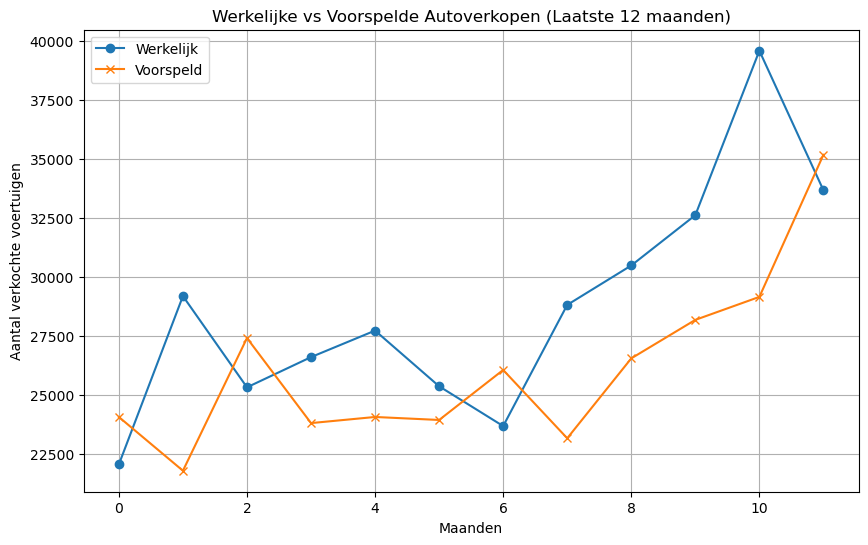

In [11]:
# Plot: Werkelijk vs Voorspeld
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Werkelijk', marker='o')
plt.plot(predictions, label='Voorspeld', marker='x')
plt.title('Werkelijke vs Voorspelde Autoverkopen (Laatste 12 maanden)')
plt.xlabel('Maanden')
plt.ylabel('Aantal verkochte voertuigen')
plt.legend()
plt.grid(True)
plt.show()


> laat mooi zien dat de voorspellingen de trend globaal volgen, al misy hij  soms de pieken/dalen (vooral bij hogere verkoopaantallen). Lijkt mij ook goed om onderzoek uit te voeren wat voor nieuws gebeurt bij de pieken/dalen 

### Feature importance using Leave One Feature Out (LOFO) Importance

In [ ]:
https://elicit.com/review/34f86fac-9b35-4237-9b80-24816323e242